<a href="https://colab.research.google.com/github/HimashiRathnayake/Hate-Speech-Humor-Detection/blob/branch-1/Humor_Hate_Speech_BaseLine_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Hate Speech Detection & Humor Detection for Code-mixed Sinhala-English Data </h1>

# User Parameters

In [1]:
Host = "colab" #@param ["colab", "AWS", "GCP"]
technique = "humor" #@param ["humor", "hate speech"]

EMBEDDING_SIZE = 300 #@param [50, 150, 200, 250, 300, 350, 400, 450, 500]
embedding_type = "fasttext" #@param ["fasttext","word2vec"]
experiment_no = "06" #@param [] {allow-input: true}
model_type = "BiLSTM" #@param ["RNN","GRU", "LSTM", "BiLSTM"]
over_sampling_technique = "" #@param ["", "ROS","ADASYN", "SMOTE", "BorderlineSMOTE"]
sampling_strategy = "" #@param [] {allow-input: true}

stack_modeles = "" #@param ["","2","3"]
apply_CNN = False #@param {type:"boolean"}
apply_TPU_support = False #@param {type:"boolean"}

model_name = model_type + "_model"
if(stack_modeles == "2" or stack_modeles == "3"):
  model_name = "stacked_" + model_name + "_" + stack_modeles
if(apply_CNN):
  model_name = "CNN_" + model_name

if technique == "humor" :
  NO_OUTPUT_LAYERS = 2
  tag_set = ["Humorous", "Non-Humorous"]
elif technique == "hate speech":
  NO_OUTPUT_LAYERS = 3
  tag_set = ["Abusive", "Hate-Inducing", "Not offensive"]

print(model_name + " for " + technique + " detection")

BiLSTM_model for humor detection


# Folder Paths

In [2]:
folder_path = "/content/drive/Shareddrives/FYP/"
data_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Annotations/Final/All_tagged_data/çompleted_draft.csv"

context = 5
word_embedding_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
word_embedding_keydvectors_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/keyed_vectors/" +  "embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
embedding_matrix_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Humor_HateSpeech detection/Implementation/embedding_matrix/"+embedding_type+'_'+str(EMBEDDING_SIZE)

experiment_name = str(experiment_no) + "_"+ model_name +"_"+embedding_type+"_"+str(EMBEDDING_SIZE)+"_"+str(context)
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/"+technique+"/"+experiment_name+".hdf5"

# Dependencies

In [3]:
# # !pip uninstall keras-nightly
# !pip uninstall -y tensorflow
# !pip install h5py==2.10.0  
# !pip install tensorflow==1.15.2
# !pip install q keras==2.3.1

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 110.5 MB 30 kB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 3.8 MB 60.0 MB/s 
     |████████████████████████████████| 503 kB 38.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=5c2390a325fa9cf23310e0c089cf5d99d6f0f8efcb9e7b7875c938a41c11a907
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uni

In [4]:
from __future__ import print_function

import collections
import pickle
import re
import random
import sys
import os 
import time

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.fasttext import FastText
from gensim.models import word2vec

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import cumsum

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras import backend as K
from keras.models import Sequential,Model,load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Add,TimeDistributed, Bidirectional,SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2, l1_l2
from keras.constraints import maxnorm
from keras import callbacks
from keras.utils import generic_utils,plot_model
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from google.colab import data_table
from google.colab import drive

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


**Add TPU Support**

In [6]:
if (apply_TPU_support):

  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  # tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Load Data

In [7]:
all_data = pd.read_csv(data_path)

if (technique == "humor"):
  all_data = all_data[['Sentence', 'Humor']]
elif (technique == "hate speech"):
  all_data = all_data[['Sentence', 'Hate_speech']]
else:
  all_data = all_data[['Sentence', 'Offensive']]

all_data.columns = ['Sentence', 'Label']
data_table.DataTable(all_data, include_index=False, num_rows_per_page=10)

,Sentence,Label
0,Ammage Adarayta❤️Eka Dawasak Madi Neda❤️🙏❤️,Non-humorous
1,We need IPL Champions leak data offers ..pleas...,Non-humorous
2,#VPN #ummmaaa #proud_be,Non-humorous
3,chandimal.. uuu thama mulu tem ekama kaaa gaha...,Non-humorous
4,sltgo,Non-humorous
...,...,...
13513,Me mase web family plus packge eke total eka 6...,Non-humorous
13514,munge Dan data kapana widiye awulk thiyenwa,Non-humorous
13515,I didn't received loyalty data past months. Pl...,Non-humorous
13516,worst service ever!!! stolen more than 10GB fr...,Non-humorous


In [8]:
output_labels = all_data['Label'].unique()
print('Output Labels:', output_labels)

label_group =  all_data.groupby('Label')['Label'].count()
print(label_group)

Output Labels: ['Non-humorous' 'Humorous']
Label
Humorous         1305
Non-humorous    12213
Name: Label, dtype: int64


## Count Tokens

In [9]:
# data_path = folder_path + "corpus/new/preprocess_from_isuru/gossip_lanka_all_comments.csv"
# # "corpus/new/preprocess_from_isuru/lankadeepa_comments_with_article_2.csv"
# data = pd.read_csv(data_path)

# def count_tokens(pandas_df):

#   count = 0
#   for index, row in pandas_df.iterrows():
#     comment_words,article_words = 0,0
#     if (type(row['comment']) == str) :
#       comment_words = len(row['comment'].split())
#     # if (type(row['article']) == str) :
#     #   article_words = len(row['article'].split())
#     count += (comment_words + article_words)
#   return count

# tokens = count_tokens(data)
# print(tokens)

In [10]:
# all_data_path = folder_path + 
# "corpus/new/tagged_comments_all_with_punctuation_marks.csv" done
# "corpus/new/tagged_comments_all_with_punctuation_marks_question_only.csv"
# corpus/new/tagged_comments_all_without_punctuation_marks.csv

# all_data = pd.read_csv(all_data_path)

## Some other Preprocessing 

In [11]:
# all_data['comment'] = all_data['comment'].str.replace('?', '')

In [12]:
# all_data.to_csv(folder_path + 'corpus/new/tagged_comments_all_without_punctuation_marks.csv')

In [13]:
# all_data['label'].value_counts()
# set(lankadeepa_data.comment.apply(list).sum())

# Create Input

## comment-label split

In [14]:
# edit this later 
def text_preprocessing(train_data,test_data):
  train_data_texts = train_data['Sentence']
  train_data_labels = train_data['Label']
  test_data_texts = test_data['Sentence']
  test_data_labels = test_data['Label']


  comment_texts = []
  comment_labels = []

  train_text = []
  test_text = []
  train_labels=[]
  test_labels=[]

  for label in train_data_labels:
    if label == "POSITIVE":
      train_labels.append(1)
    else:
      train_labels.append(0)
  comment_labels.append(train_labels)

  for label in test_data_labels:
    if label == "POSITIVE":
      test_labels.append(1)
    else:
      test_labels.append(0)
  comment_labels.append(test_labels)
  

  for comment in train_data_texts:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    train_text.append(lines)
  comment_texts.append(train_text)

  for comment in test_data_texts:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    test_text.append(lines)
  comment_texts.append(test_text)


  return comment_texts,comment_labels

# edit this later 
def text_preprocessing_1(data):
  comments = data['Sentence']
  labels = data['Label']

  comments_splitted = []
  labels_encoded = []

  for label in labels:
    if label == "POSITIVE":
      labels_encoded.append(1)
    else:
      labels_encoded.append(0)

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)
  return comments_splitted,labels_encoded


def text_preprocessing_2(data):
  comments = data['Sentence']
  labels = data['Label']

  comments_splitted = []

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)

  return comments_splitted,labels

## Takenize and Split Data

In [15]:
comment_texts, comment_labels = text_preprocessing_2(all_data)

# prepare tokenizer

t = Tokenizer()
t.fit_on_texts(comment_texts)
vocab_size = len(t.word_index) + 1
print(vocab_size)

28401


In [16]:
encoded_docs = t.texts_to_sequences(comment_texts)

In [17]:
max_length = len(max(encoded_docs, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length)
comment_labels = np.array(comment_labels)
padded_docs = np.array(padded_docs)

In [18]:
comment_labels = pd.get_dummies(comment_labels).values
print('Shape of label tensor:', comment_labels.shape)

Shape of label tensor: (13518, 2)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=0.1, random_state=0)

## Oversampling

In [20]:
def apply_oversampling(x, y):

  (unique, counts) = np.unique(y, axis=0, return_counts=True)
  print("Class Distribution Without Oversampling", counts)

  # define oversampling strategy
  if (over_sampling_technique == ""):
    return x, y
  elif (over_sampling_technique == "ROS"):
    if (technique=="humor"):
      oversample = RandomOverSampler(sampling_strategy = float(sampling_strategy))
    else:
      sampling_ratio = sampling_strategy.split(":");
      oversample = RandomOverSampler(ratio = {
          0:int(counts[0]*float(sampling_ratio[0])), 
          1:int(counts[0]*float(sampling_ratio[1])), 
          2:int(counts[0]*float(sampling_ratio[2]))
          })
  elif (over_sampling_technique == "ADASYN"):
    oversample = ADASYN(sampling_strategy="minority")
  elif (over_sampling_technique == "SMOTE"):
    oversample = SMOTE()
  elif (over_sampling_technique == "BorderlineSMOTE"):
    oversample = BorderlineSMOTE()

  # fit and apply the transform
  X_over, y_over = oversample.fit_resample(x, y)
  if(technique=="humor"):
    y_over = pd.get_dummies(y_over.flatten())

  (unique, counts) = np.unique(y_over, axis=0, return_counts=True)
  print("Class Distribution After Oversampling", counts)

  return X_over, y_over

In [21]:
# (unique, counts) = np.unique(y_over, return_counts = True)
# frequencies = np.asarray((unique, counts)).T
# print(frequencies)

# Word Embedding

## Generate Embedding Metrix

In [22]:
def generate_embedding_metrix():
  if (embedding_type == 'fasttext'):
    word_embedding_model = FastText.load(word_embedding_path)
  else:
    word_embedding_model = word2vec.Word2Vec.load(word_embedding_path)
    
  word_vectors = word_embedding_model.wv
  word_vectors.save(word_embedding_keydvectors_path)
  word_vectors = KeyedVectors.load(word_embedding_keydvectors_path, mmap='r')

  embeddings_index = dict()
  for word, vocab_obj in word_vectors.vocab.items():
    embeddings_index[word]=word_vectors[word]

  # create a weight matrix for words in training docs
  embedding_matrix = zeros((vocab_size, EMBEDDING_SIZE))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  pickle.dump(embedding_matrix, open(embedding_matrix_path, 'wb'))
  return embedding_matrix

## Load Embedding Matrix

In [23]:
def load_word_embedding_matrix():
  f = open(embedding_matrix_path, 'rb')
  embedding_matrix= np.array(pickle.load(f))
  return embedding_matrix

# Models

## RNN(LSTM/GRU) model

In [24]:
def RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims)(embedding)

    x = Dense(hidden_dims, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer=Adadelta(lr=0.95, epsilon=1e-06),
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       f1
                       ])
    
    print(model.summary())
    return model

def stacked_RNN_model_2(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "stacked_RNN_model_2")

    model.compile(loss={'output':'categorical_crossentropy'},
          optimizer=Adadelta(lr=0.95, epsilon=1e-06),
          metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                       f1])

    print(model.summary())
    return model

def stacked_RNN_model_3(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims,return_sequences=True)(x)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name="stacked_RNN_model_3")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    print(model.summary())
    return model

## CNN+RNN(LSTM /GRU) model 

In [25]:
def CNN_RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    conv4 = Convolution1D(NB_FILTERS,
                          4,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv4')(embedding)
    maxConv4 = MaxPooling1D(pool_length=2,
                             name='maxConv4')(conv4)

    conv5 = Convolution1D(NB_FILTERS,
                          5,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv5')(embedding)
    maxConv5 = MaxPooling1D(pool_length=2,
                            name='maxConv5')(conv5)

    x = keras.layers.Concatenate(axis=1)([maxConv4, maxConv5])

    x = Dropout(drop_out_value_2)(x)

    x = RNN_layer(hidden_dims)(x) #rnn_output_size


    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "CNN+RNN model")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    return model

## BiLSTM model 

In [26]:
def BiLSTM_model(maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
  input = Input(shape=(maxlen,))
  embedding = Embedding(MAX_FEATURES, EMBEDDING_SIZE, weights=[EMBEDDING_MATRIX], input_length=maxlen)(input)

  model =  Bidirectional (LSTM (300, return_sequences=True, dropout=drop_out_value_1, kernel_regularizer=l2(0.01)), merge_mode='concat')(embedding)
  model = TimeDistributed(Dense(300, activation='relu'))(model)
  model = Flatten()(model)
  # model = Dense(300, activation='relu')(model) # extra dense layer
  output = Dense(NO_OUTPUT_LAYERS, activation='softmax', name='output')(model)
  model = Model(input, output)

  model.compile(loss={'output':'categorical_crossentropy'},
      optimizer='adam',
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                f1])
  
  return model

# Train and Evaluate Model

## Custom F1 Implementation

In [27]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Macro Averages Callback Implementation

In [28]:
class MacroMetrics(Callback):
    def __init__(self, valid_data):
        super(MacroMetrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_macro_f1'] = _val_f1
        logs['val_macro_recall'] = _val_recall
        logs['val_macro_precision'] = _val_precision
        print("val_macro_precision: %f - val_macro_recall: %f - val_macro_f1: %f" % (_val_precision, _val_recall, _val_f1))
        return

## Train and Validate model

In [29]:
def Train_Model_old(model,X_train, X_test, y_train, y_test):

  print('Training and Testing...')
  test_accs = []
  first_run = True


  acc=[]
  val_acc=[]
  loss=[]
  val_loss=[]
  best_val_acc = 0
  best_test_acc = 0
  for j in range(nb_epoch):
      a = time.time()
      his = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      validation_data=[X_test, y_test],
                      shuffle=True,
                      epochs=1, verbose=verbosity)
      acc+=his.history['accuracy']
      val_acc+=his.history['val_accuracy']
      loss+=his.history['loss']
      val_loss+=his.history['val_loss']
      # print('Epoch %d/%d\t%s' % (j + 1, nb_epoch, str(his.history)))
      if his.history['val_accuracy'][0] >= best_val_acc:
          score, test_acc = model.evaluate(X_test, y_test,
                                      batch_size=batch_size,
                                      verbose=2)
          best_val_acc = his.history['val_accuracy'][0]
          best_test_acc = test_acc
          print('Got best epoch  best val acc is %f test acc is %f' %
                (best_val_acc, best_test_acc))
          if len(test_accs) > 0:
              print('Current avg test acc:', str(np.mean(test_accs)))
      b = time.time()
      cost = b - a
      left = (nb_epoch - j - 1)
      print('One round cost %ds, %d round %ds %dmin left' % (cost, left,
                                                            cost * left,
                                                            cost * left / 60.0))
      test_accs.append(best_test_acc)

  print('Avg test acc:', str(np.mean(test_accs)))
  return model

In [30]:
def Train_Model(model, X_train, y_train, cross_validation = False):

  print('Training and Testing...')

  x_train_train, x_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=0)

  X_over, y_over = apply_oversampling(x_train_train, y_train_train);

  es = EarlyStopping(monitor='val_macro_f1', mode='max', verbose=1, patience=5)
  checkpoint = ModelCheckpoint(model_save_path, monitor='val_macro_f1', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), checkpoint , es]

  if (cross_validation):
    callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), es]

  his = model.fit(X_over, y_over, validation_data=[x_val, y_val], epochs=NB_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
  return model, his

# Cross Validation

In [31]:
def Do_Cross_Validation(X,y):

  # Define per-fold score containers
  loss_per_fold = []
  acc_per_fold = []
  precision_per_fold = []
  recall_per_fold = []
  f1_per_fold = []

  macro_f1_per_fold = []
  macro_precision_per_fold = []
  macro_recall_per_fold = []

  kfold = KFold(n_splits=FOLDS, shuffle=True)

  fold_no = 1
  inputs = X
  targets = y

    # for train, test in kfold.split(inputs, targets):
  #   folds['fold_{}'.format(count)] = {}
  #   folds['fold_{}'.format(count)]['train'] = train.tolist()
  #   folds['fold_{}'.format(count)]['test'] = test.tolist()
  #   count += 1
  #   print(len(folds) == n_splits)#assert we have the same number of splits
  #   #dump folds to json
  #   import json
  #   with open(folder_path + 'folds.json', 'w') as fp:
  #       json.dump(folds, fp)

  # #load to dict to be used
  # with open('folds.json') as f:
  #     kfolds = json.load(f)

  # for key, val in kfolds.items():
  #     train = val['train']
  #     test = val['test']
  
  for train, test in kfold.split(inputs, targets):

    model = build_model()
    # model = RNN_model(GRU, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    
    # RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model, his = Train_Model(model, inputs[train], targets[train], cross_validation=True)
 
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    y_val_pred = model.predict(inputs[test])
    y_val_pred_cat = (np.asarray(y_val_pred)).round()
    y_val = targets[test]

    # Get performance metrics(macro averages) after each fold
    macro_f1, macro_precision, macro_recall = f1_score(y_val, y_val_pred_cat, average='macro'), precision_score(y_val, y_val_pred_cat, average='macro'), recall_score(y_val, y_val_pred_cat, average='macro')

    print(f"""Score for fold {fold_no}:
     {model.metrics_names[0]} of {scores[0]}; 
     {model.metrics_names[1]} of {scores[1]*100}% ;
     {model.metrics_names[2]} of {scores[2]*100}% ;
     {model.metrics_names[3]} of {scores[3]*100}% ;
     {model.metrics_names[4]} of {scores[4]*100}% ;
     macro precision of {macro_precision*100}% ;
     macro recall of {macro_recall*100}% ;
     macro f1 of {macro_f1*100}% ;
     """)
    
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    f1_per_fold.append(scores[4])

    macro_f1_per_fold.append(round(macro_f1, 6))
    macro_precision_per_fold.append(round(macro_precision, 6))
    macro_recall_per_fold.append(round(macro_recall, 6))

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f"""> Fold {i+1} - 
    Loss: {loss_per_fold[i]} - 
    Accuracy: {acc_per_fold[i]}% - 
    Precesion: {precision_per_fold[i]}% - 
    Recall: {recall_per_fold[i]}% - 
    F1: {f1_per_fold[i]}%
    Macro Precision: {macro_precision_per_fold[i]}%
    Macro Recall: {macro_recall_per_fold[i]}%
    Macro F1: {macro_f1_per_fold[i]}%
    """)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Precision: {np.mean(precision_per_fold)}')
  print(f'> Recall: {np.mean(recall_per_fold)}')
  print(f'> F1: {np.mean(f1_per_fold)}')
  print(f'> Macro Precision: {np.mean(macro_precision_per_fold)}')
  print(f'> Macro Recall: {np.mean(macro_recall_per_fold)}')
  print(f'> Macro F1: {np.mean(macro_f1_per_fold)}')
  print('------------------------------------------------------------------------')

# Plot Graphs

In [32]:
def Plot_graphs(metric,val_metric,metric_name):

  epochs=range(len(metric)) # Get number of epochs

  if metric_name == "accuracy":
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()

  elif metric_name == "loss" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()

  elif metric_name == "f1" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation F1')
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(["F1", "Validation F1"])

    plt.figure()


  # Expected Output
  # A chart where the validation loss does not increase sharply!

# Main Method

## Set Hyper-Parameters

In [33]:
# EMBEDDING_MATRIX = generate_embedding_metrix()
EMBEDDING_MATRIX = load_word_embedding_matrix()

In [34]:
MAX_FEATURES = EMBEDDING_MATRIX.shape[0] #vocab_size
VERBOSITY = 1
VALIDATION_SPLIT = 0.1
NB_EPOCHS = 10
FOLDS = 5 #10

BATCH_SIZE = 32 # 64, 128
NB_FILTERS = 200
FILTER_LENGTH = 4 # test with 2,3,4,5
HIDDEN_DIMS = NB_FILTERS * 2
MAX_LEN = max_length #275 #test with other values(only this value work for now)
DROPOUT_VALUE_1 = 0.5 #0.8 #0.3
DROPOUT_VALUE_2 = 0.5
L2_REG= 0.01

RNN = GRU

## Build and Compile Model

In [35]:
def build_model() :
  model = None

  if (model_type == "RNN" or model_type == "GRU" or model_type == "LSTM" ):
    # configure layer
    layer = None
    if (model_type == "RNN"):
      layer = RNN
    if (model_type == "GRU"):
      layer = GRU
    if (model_type == "LSTM"):
      layer = LSTM
    
    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_RNN_model_2(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_RNN_model_3(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

  elif (model_type == "BiLSTM" ):

    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_BiLSTM_model_2(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_BiLSTM_model_3(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

    
  return model

## Train and Test Model (Holdout Method)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


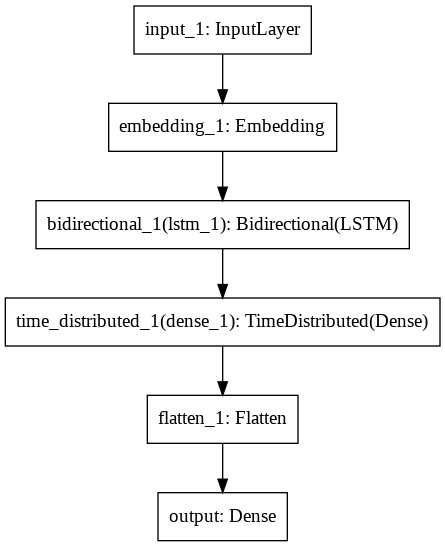

In [36]:
if (apply_TPU_support):
  with tpu_strategy.scope():
    model = build_model()
else:
  model = build_model()
# model = stacked_RNN_model_3(LSTM, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
plot_model(model,to_file="./model.png")

### Train Model

Training and Testing...
Class Distribution Without Oversampling [9938  280  731]


Train on 10949 samples, validate on 1217 samples
Epoch 1/10
10949/10949 [==============================] - 720s 66ms/step - loss: 1.0168 - accuracy: 0.9040 - precision: 0.9007 - recall: 0.8751 - f1: 0.9023 - val_loss: 0.4254 - val_accuracy: 0.8973 - val_precision: 0.9068 - val_recall: 0.9003 - val_f1: 0.8998


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val_macro_precision: 0.299096 - val_macro_recall: 0.333333 - val_macro_f1: 0.315288

Epoch 00001: val_macro_f1 improved from -inf to 0.31529, saving model to /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/hate speech/06_BiLSTM_model_fasttext_300_5.hdf5
Epoch 2/10
10949/10949 [==============================] - 722s 66ms/step - loss: 0.3912 - accuracy: 0.9067 - precision: 0.9071 - recall: 0.9000 - f1: 0.9072 - val_loss: 0.4191 - val_accuracy: 0.8915 - val_precision: 0.9088 - val_recall: 0.9003 - val_f1: 0.8916
val_macro_precision: 0.532485 - val_macro_recall: 0.371001 - val_macro_f1: 0.383907

Epoch 00002: val_macro_f1 improved from 0.31529 to 0.38391, saving model to /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/hate speech/06_BiLSTM_model_fasttext_300_5.hdf5
Epoch 3/10
10949/10949 [==============================] - 721s 66ms/step - loss: 0.3609 - accuracy: 0.9111 - precision: 0.9107 - recall: 0.9003 - f1: 

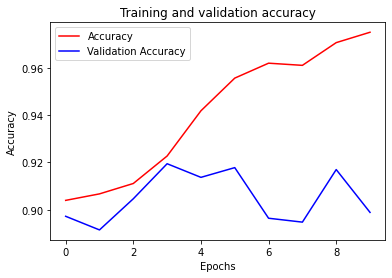

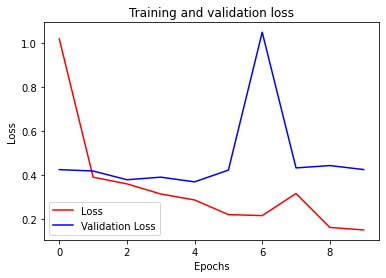

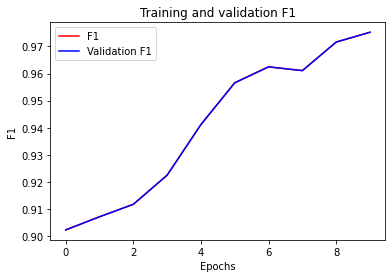

<Figure size 432x288 with 0 Axes>

In [ ]:
# trained_model = Train_Model_old(model,X_train, X_test, y_train, y_test)
if (apply_TPU_support):

  trained_model, his = Train_Model(model, X_train, y_train, cross_validation = False)

  accuracy = his.history['accuracy']
  val_accuracy = his.history['val_accuracy']
  loss = his.history['loss']
  val_loss = his.history['val_loss']
  f1 = his.history['f1']
  val_f1 = his.history['f1']
  val_macro_f1 = his.history['val_macro_f1']

  Plot_graphs(accuracy,val_accuracy, "accuracy")
  Plot_graphs(loss,val_loss, "loss")
  Plot_graphs(f1, val_f1, "f1")

### Restart runtime and import Relibraries
There is a bug, if run time isn't restart after this point, It's going to malfunction.

In [ ]:
# #os.kill(os.getpid(), 9)
# exit()

In [ ]:
# from keras.models import Sequential,Model,load_model
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

# experiment_no = 100
# model_name = "RNN"
# experiment_name = folder_path + "Sentiment Analysis/CNN RNN/experiments/" + model_name +str(experiment_no)+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(context)

# model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/weights_best_"+model_name+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(experiment_no)+".hdf5"

### Test Model

#### Load Weights to Model

In [ ]:
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/" + technique + "/"+ experiment_no +"_" + model_type + "_model_fasttext_300_5.hdf5"
# model_save_path = "/content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/hate speech/06_BiLSTM_model_fasttext_300_5.hdf5"

print("Load model from "+model_save_path)
loaded_model  = keras.models.load_model(model_save_path, custom_objects={"f1": f1}, compile=False)
print("loaded " + loaded_model.name)

# _, train_acc,train_f1 = loaded_model.evaluate(X_train, y_train, verbose=1)
# _, test_acc,test_f1= loaded_model.evaluate(X_test, y_test, verbose=1)
# print('Train_acc: %.3f, Test_acc: %.3f, Train_f1: %.3f,  Test_f1: %.3f' % (train_acc, test_acc,train_f1,test_f1))

Load model from /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/hate speech/06_BiLSTM_model_fasttext_300_5.hdf5
loaded model_1


#### Get Predictions

In [ ]:
predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

labels = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels,predictions )

# classification_report
report = classification_report(labels, predictions, digits=4,output_dict=True)
report_print = classification_report(labels, predictions, digits=4)
print(report_print)

# save report to drive
report_save_path = folder_path + "Humor_HateSpeech detection/Implementation/reports/"+model_name+"_"+technique+"_"+ experiment_no+"_report.csv"
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(report_save_path)


1352/1352 [==============================] - 24s 18ms/step
              precision    recall  f1-score   support

           0     0.4800    0.4138    0.4444        87
           1     0.4500    0.2727    0.3396        33
           2     0.9475    0.9667    0.9570      1232

    accuracy                         0.9142      1352
   macro avg     0.6258    0.5511    0.5804      1352
weighted avg     0.9053    0.9142    0.9090      1352



In [ ]:
train_data_original, test_data_original = train_test_split(all_data, test_size=0.1, random_state=0)

predictions_series = pd.Series(predictions)
predictions_1 = pd.get_dummies(predictions_series).idxmax(1)

In [ ]:
data_frame = pd.DataFrame({'Sentence': test_data_original['Sentence'], 'Label': test_data_original['Label'], 'Predictions': np.array(predictions_1)})

def apply_label_name(value):
  return tag_set[value]

data_frame["Predictions"] = data_frame["Predictions"].apply(apply_label_name)

prediction_save_name  = folder_path + "Humor_HateSpeech detection/Implementation/predictions/"+model_name+"_"+technique+"_"+ experiment_no+"_predictions_with_labels.csv"
data_frame.to_csv(prediction_save_name)
data_table.DataTable(data_frame, include_index=False, num_rows_per_page=10)

,Sentence,Label,Predictions
12114,මේක තමයි හොඳම වංචාව.,Abusive,Abusive
3505,frree da,Not offensive,Not offensive
13156,Alawwata gendoooo,Not offensive,Not offensive
2364,Balummhara fiber diyan labba,Abusive,Abusive
1136,Enjoy good times streaming with the Automatic ...,Not offensive,Not offensive
...,...,...,...
9997,නැතහොත් SLT පාරිභෝගිකයන් ඉක්මනින් වෙනත් ආයතනයක...,Not offensive,Not offensive
16,හොඳ වැඩේ....මෙයැයිලගේ හැටි දන්නෑ ඔයැයිලා....❤️...,Not offensive,Not offensive
578,Now I bought 1Gb but free 1 Gb is not there??,Not offensive,Not offensive
2305,හරීම ලස්සනයි මෙහෙම හොද පුතාලත් ලෝකයේ ඉන්නවා,Not offensive,Not offensive


### Print confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

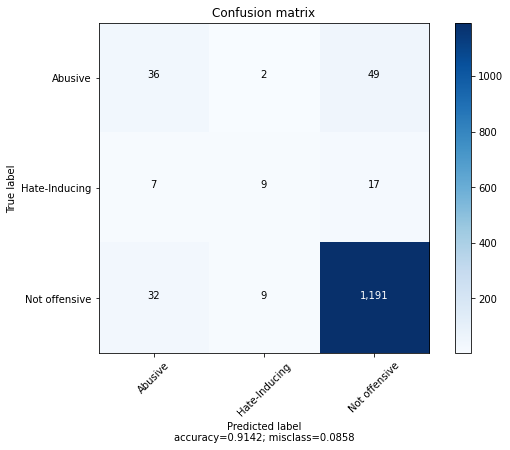

In [ ]:
if (technique=="humor"):
  plot_confusion_matrix(cm, ["Humorous","Non humorous"], normalize=False)
else:  
  plot_confusion_matrix(cm, ["Abusive","Hate-Inducing","Not offensive"], normalize=False)

## Train and Test Model (Cross Validation)

In [ ]:
with tpu_strategy.scope():
  Do_Cross_Validation(padded_docs, comment_labels)

------------------------------------------------------------------------
Training for fold 1 ...
Training and Testing...
Class Distribution Without Oversampling [8767  965]
Class Distribution After Oversampling [8767 4383]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train on 13150 samples, validate on 1082 samples
Epoch 1/10
13150/13150 [==============================] - 893s 68ms/step - loss: 1.1421 - accuracy: 0.7336 - precision_1: 0.7109 - recall_1: 0.7109 - f1: 0.7336 - val_loss: 0.4932 - val_accuracy: 0.8373 - val_precision_1: 0.7379 - val_recall_1: 0.7379 - val_f1: 0.8374
val_macro_precision: 0.603213 - val_macro_recall: 0.681662 - val_macro_f1: 0.622808
Epoch 2/10
13150/13150 [==============================] - 891s 68ms/step - loss: 0.5159 - accuracy: 0.8507 - precision_1: 0.7690 - recall_1: 0.7690 - f1: 0.8507 - val_loss: 0.4196 - val_accuracy: 0.9048 - val_precision_1: 0.7962 - val_recall_1: 0.7962 - val_f1: 0.9051
val_macro_precision: 0.685415 - val_macro_recall: 0.668594 - val_macro_f1: 0.676446
Epoch 3/10
13150/13150 [==============================] - 894s 68ms/step - loss: 0.7895 - accuracy: 0.9132 - precision_1: 0.8175 - recall_1: 0.8175 - f1: 0.9132 - val_loss: 0.7455 - val_accuracy: 0.9140 - val_precision_1: 0.8355 - val_recall_1

# Hyperparameter Tuning

In [39]:
def tune_hyperparameters(model_build_fn):
  # fix random seed for reproducibility
  seed = 7
  np.random.seed(seed)

  model = KerasClassifier(build_fn=model_build_fn, maxlen=MAX_LEN, hidden_dims=HIDDEN_DIMS, l2_reg= L2_REG, verbose=VERBOSITY)

  # optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  maxlen_list  = [210]
  hidden_dims_list = [300, 400, 500, 600]
  l2_reg_list = [0.01, 0.02]
  drop_out_value_list = [0.5, 0.8]
  # tune for kernal size 2,3,4,5

  param_grid = dict(RNN_layer = [LSTM], maxlen=maxlen_list, hidden_dims = hidden_dims_list, l2_reg= l2_reg_list, drop_out_value_1 = drop_out_value_list, drop_out_value_2 = l2_reg_list)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=FOLDS, verbose = 10 )
  grid_result = grid.fit(padded_docs, comment_labels)

  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [40]:
# with tpu_strategy.scope():
tune_hyperparameters(RNN_model)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] RNN_layer=<class 'keras.layers.recurrent.LSTM'>, drop_out_value_1=0.5, drop_out_value_2=0.01, hidden_dims=300, l2_reg=0.01, maxlen=275 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_2 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_3 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_4 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.3s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.8s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_6 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   36.4s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_7 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.4s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_8 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   55.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_9 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_10 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_11 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_12 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_13 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_14 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_15 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_16 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_17 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_18 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_19 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_20 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_21 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_22 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_23 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_24 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_25 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_26 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_27 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_28 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_29 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_30 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_31 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_32 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_33 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_34 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_35 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_36 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_37 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_38 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_39 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_40 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_41 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_42 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_43 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_44 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_45 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_46 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_47 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_48 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_49 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_50 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_51 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_52 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_53 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_54 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_55 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_56 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_57 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_58 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_59 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_60 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 500)               1602000   
_________________________________________________________________
mlp (Dense)                  (None, 500)               250500    
_________________________________________________________________
drop (Dropout)               (None, 500)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_61 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_62 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_63 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(600, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_64 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 600)               2162400   
_________________________________________________________________
mlp (Dense)                  (None, 600)               360600    
_________________________________________________________________
drop (Dropout)               (None, 600)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 12

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 32.9min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_65 (Dropout)         (None, 275, 300)          0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 300)               721200    
_________________________________________________________________
mlp (Dense)                  (None, 300)               90300     
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 60